# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [9]:
!pip install -U scikit-learn > /dev/null

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.



In [10]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import math

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [11]:
df = pd.read_csv('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [12]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [13]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1071,0,50.0,43100.0,2,2
3494,1,25.0,50500.0,0,0
3120,0,40.0,34100.0,1,0
3001,1,18.0,13300.0,1,0
3489,0,35.0,43600.0,1,0
2431,1,27.0,61000.0,0,0
2649,1,29.0,38800.0,5,0
164,1,22.0,43300.0,1,0
3323,0,28.0,36900.0,0,0
2338,1,27.0,45900.0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [15]:
def change_dtype(df, field, dtype=np.uint8):
    """
    Fix the dtypes for features
    """
    try:
        df[field] = df[field].astype(dtype)
    except:
        print(f'Conversion for {field} failed...')

In [19]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:
cols = {
        'gender': np.uint8, 
        'age': np.uint8, 
        'family_members': np.uint8, 
        'insurance_benefits': np.uint8,
        'income': np.int32
}
for col in cols:
    change_dtype(df, col, cols[col])

In [20]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   uint8
 1   age                 5000 non-null   uint8
 2   income              5000 non-null   int32
 3   family_members      5000 non-null   uint8
 4   insurance_benefits  5000 non-null   uint8
dtypes: int32(1), uint8(4)
memory usage: 39.2 KB


In [21]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [22]:
# check for duplicates
df.duplicated().sum()

153

In [23]:
# percentage of duplicates
df.duplicated().sum() / df.shape[0]

0.0306

In [24]:
df[df.duplicated()].head()

,gender,age,income,family_members,insurance_benefits
281,1,39,48100,1,0
488,1,24,32900,1,0
513,0,31,37400,2,0
718,1,22,32600,1,0
785,0,20,35800,0,0


In [25]:
df = df.drop_duplicates()

In [26]:
df.shape

(4847, 5)

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

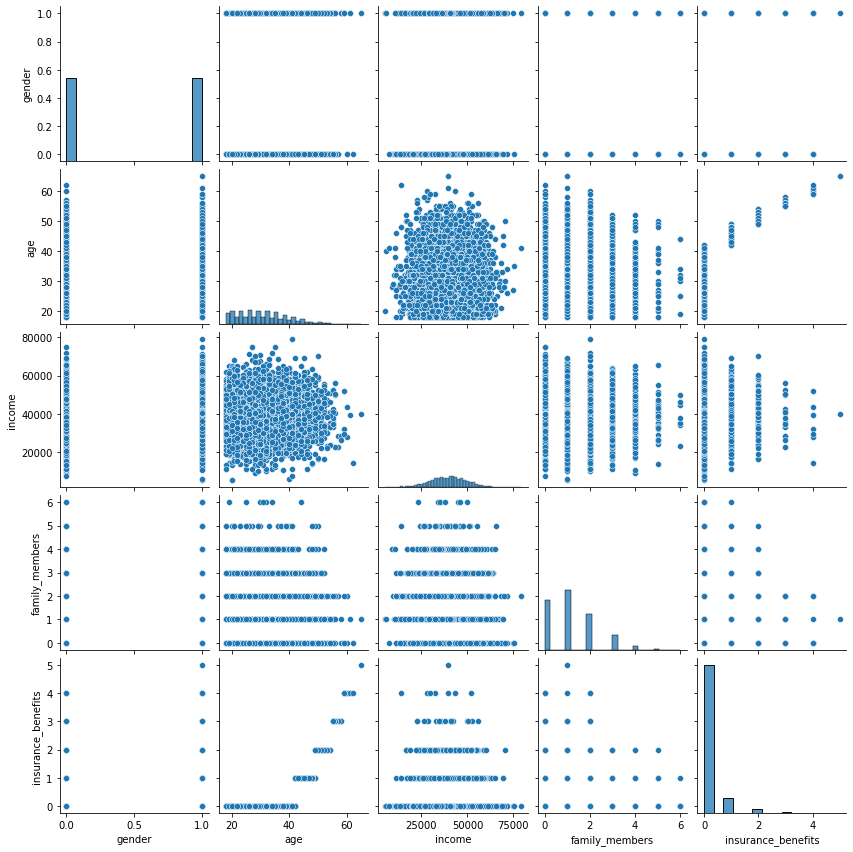

In [27]:
g = sns.pairplot(df)
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [28]:
# correlation matrix
df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.001953,0.015456,-0.007315,0.011565
age,0.001953,1.000000,-0.017386,-0.009064,0.654964
income,0.015456,-0.017386,1.000000,-0.031687,-0.013123
family_members,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
insurance_benefits,0.011565,0.654964,-0.013123,-0.039303,1.000000


1) `age` has a moderately positive correlation with `insurance_benefits`.

**Conclusion**

1) Each observation describes an insurance members details such as, `gender`, `age`, `income`, `family_benefits`, and `insurance_benfits`
they receive.

2) The `age` distribution is right-skewed, and `income` distribution appears to be normally distributed.

3) There are no missing values.

4) There are 153 (3%) duplicates.

5) There is a moderately strong positive correlation between `age` of insured and `insurance_benfits`.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [31]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [32]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    np.random.seed(42)
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n]], k, return_distance=True)
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [33]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [41]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3878,0.0,0.292308,0.427848,0.000000,0
1684,0.0,0.446154,0.608861,0.500000,0
1044,0.0,0.446154,0.507595,0.000000,0
4807,0.0,0.661538,0.436709,0.666667,1
1538,0.0,0.476923,0.617722,0.166667,0


Now, let's get similar records for a given one for every combination

In [42]:
def check_knn_results(df, k, n, scaling='Scaled', metrics=[]):
    """
    Helper fucnction
    """
    for metric in metrics:
        print('{} results for {}'.format(scaling, metric))
        print('-'*50)
        print(get_knn(df, n, k, metric))
        print()

In [43]:
# reset the indices as the results with .loc and .iloc
# don't line up
df = df.reset_index(drop=True)


In [44]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


In [45]:
# for insured member 100. Without scaling
metrics = ['euclidean', 'manhattan']
check_knn_results(df[feature_names], k=5, n=100, scaling='Unscaled', metrics=metrics)

Unscaled results for euclidean
--------------------------------------------------
      gender  age  income  family_members  distance
100        0   19   37300               1  0.000000
1803       0   20   37300               2  1.414214
4147       1   19   37300               2  1.414214
2569       1   19   37300               0  1.414214
1078       0   22   37300               3  3.605551

Unscaled results for manhattan
--------------------------------------------------
      gender  age  income  family_members  distance
100        0   19   37300               1       0.0
2569       1   19   37300               0       2.0
1803       0   20   37300               2       2.0
4147       1   19   37300               2       2.0
1078       0   22   37300               3       5.0



In [46]:
# reset the indices as the results with .loc and .iloc
# don't line up
df_scaled = df_scaled.reset_index(drop=True)

In [47]:
# for insured member 100. With scaling
metrics = ['euclidean', 'manhattan']
check_knn_results(df_scaled[feature_names], k=5, n=100, metrics=metrics)

Scaled results for euclidean
--------------------------------------------------
      gender       age    income  family_members  distance
100      0.0  0.292308  0.472152        0.166667  0.000000
4765     0.0  0.292308  0.477215        0.166667  0.005063
243      0.0  0.292308  0.467089        0.166667  0.005063
1309     0.0  0.292308  0.456962        0.166667  0.015190
806      0.0  0.307692  0.470886        0.166667  0.015437

Scaled results for manhattan
--------------------------------------------------
      gender       age    income  family_members  distance
100      0.0  0.292308  0.472152        0.166667  0.000000
4765     0.0  0.292308  0.477215        0.166667  0.005063
243      0.0  0.292308  0.467089        0.166667  0.005063
1309     0.0  0.292308  0.456962        0.166667  0.015190
806      0.0  0.307692  0.470886        0.166667  0.016650



Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, without scaling, the distance metrics both, euclidean and manhattan are affected by `income`, which is on
a different scale compared with the other features.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

There are noticeable differences between the 2 metrics regardless of scaling. Euclidean distance penalizes large
values more than Manhattan does. This is evident in the 5th neighbor in both results.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [48]:
# calculate the target


df['insurance_benefits_received'] = (df['insurance_benefits'] > 0.5).astype(np.uint8)

In [49]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

In [50]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [51]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [52]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



In [53]:
train, valid = \
(
    train_test_split(df, stratify=df['insurance_benefits_received'], test_size=0.3, random_state=42)
)
features_train, target_train = train[feature_names], train['insurance_benefits_received']
features_valid, target_valid = valid[feature_names], valid['insurance_benefits_received']

In [54]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape

((3392, 4), (3392,), (1455, 4), (1455,))

In [55]:
def build_model(train, target, test, n_neighbors):
    """
    Fit a model and make predictions
    """
    np.random.seed(42)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(features_train, target)
    y_pred = model.predict(test)
    return y_pred

In [56]:
n_neighbors = 10
# using unscaled data
for k in range(1, n_neighbors+1):
    y_pred = build_model(features_train, target_train, features_valid, k)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.68
Confusion Matrix
[[0.86804124 0.01580756]
 [0.04879725 0.06735395]]

For neighbor k=2
F1: 0.40
Confusion Matrix
[[0.87835052 0.00549828]
 [0.08591065 0.03024055]]

For neighbor k=3
F1: 0.41
Confusion Matrix
[[0.87353952 0.01030928]
 [0.0838488  0.03230241]]

For neighbor k=4
F1: 0.21
Confusion Matrix
[[0.88041237 0.00343643]
 [0.1024055  0.0137457 ]]

For neighbor k=5
F1: 0.22
Confusion Matrix
[[0.8790378  0.004811  ]
 [0.10103093 0.01512027]]

For neighbor k=6
F1: 0.02
Confusion Matrix
[[0.8838488  0.        ]
 [0.11477663 0.00137457]]

For neighbor k=7
F1: 0.05
Confusion Matrix
[[0.88109966 0.00274914]
 [0.11340206 0.00274914]]

For neighbor k=8
F1: 0.03
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [1.14089347e-01 2.06185567e-03]]

For neighbor k=9
F1: 0.03
Confusion Matrix
[[0.88247423 0.00137457]
 [0.11408935 0.00206186]]

For neighbor k=10
F1: 0.02
Confusion Matrix
[[0.8838488  0.        ]
 [0.11477663 0.00137457]]



In [57]:
# reduce the target to either received benefit 1, or not received benefit 0
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)

In [58]:
train, valid = \
(
    train_test_split(df_scaled, stratify=df_scaled['insurance_benefits_received'], test_size=0.3, random_state=42)
)
features_train, target_train = train[feature_names], train['insurance_benefits_received']
features_valid, target_valid = valid[feature_names], valid['insurance_benefits_received']

In [59]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape

((3392, 4), (3392,), (1455, 4), (1455,))

In [60]:
for k in range(1, n_neighbors+1):
    y_pred = build_model(features_train, target_train, features_valid, k)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.94
Confusion Matrix
[[0.8790378  0.004811  ]
 [0.00824742 0.10790378]]

For neighbor k=2
F1: 0.91
Confusion Matrix
[[0.88109966 0.00274914]
 [0.01786942 0.09828179]]

For neighbor k=3
F1: 0.92
Confusion Matrix
[[0.87697595 0.00687285]
 [0.01168385 0.10446735]]

For neighbor k=4
F1: 0.89
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [2.33676976e-02 9.27835052e-02]]

For neighbor k=5
F1: 0.91
Confusion Matrix
[[0.87972509 0.00412371]
 [0.01580756 0.10034364]]

For neighbor k=6
F1: 0.88
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [2.40549828e-02 9.20962199e-02]]

For neighbor k=7
F1: 0.91
Confusion Matrix
[[0.88247423 0.00137457]
 [0.01718213 0.09896907]]

For neighbor k=8
F1: 0.89
Confusion Matrix
[[0.8838488  0.        ]
 [0.02268041 0.09347079]]

For neighbor k=9
F1: 0.91
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [1.92439863e-02 9.69072165e-02]]

For neighbor k=10
F1: 0.88
Confusion Matrix
[[0.8838488  0.        ]
 [0.02542955 0.09072165]]



1) Comparing KNearestNeighbhors between unscaled and scaled data shows a huge difference in the F1 score; the lowest F1 score 
produced by any model using scaled features is 88%, whereas for unscaled features it is 0.02. Clearly, showing how
the use of distance metric during fitting impacts predictions by large valued features - in this case `income`.

2) The scaled model surpasses the dummy model.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [73]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([X.shape[0], 1]), X, axis=1)
        y_pred = np.dot(X2, self.weights)
        
        return y_pred

In [74]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [75]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366679e-01  3.58042290e-02  1.95594897e-02  5.85335011e-07
 -1.21618426e-02]
RMSE: 0.36
R2: 0.66


In [76]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736668  2.32727489  0.01955949  0.04624147 -0.07297106]
RMSE: 0.36
R2: 0.66


1) Only 66% of the variance is explained by the features when the data is unscaled.

2) There is no difference in either the RMSE or R2 score post scaling; this is expected as Linear Regression makes
predictions using the units of the output, making necessary adjustments to the units of the features.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [77]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [78]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [79]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

$$ PP^{-1} = P^{-1}P = I $$

In [80]:
np.dot(P, np.linalg.inv(P))

array([[ 1.00000000e+00, -1.69848573e-16, -7.58122972e-17,
        -1.13112497e-16],
       [-6.94895396e-17,  1.00000000e+00, -7.10568689e-17,
         3.59096970e-17],
       [-1.21269339e-16, -8.01461326e-17,  1.00000000e+00,
         4.30764008e-19],
       [-3.60694539e-16, -5.55430227e-16,  3.08072404e-16,
         1.00000000e+00]])

In [81]:
np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

True

In [82]:
np.dot(X, P)

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you guess the customers' ages or income after the transformation?

1) It is clear, that the data is indecipherable.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

$$ X^{'}P^{-1} = (XP)P^{-1} = X(PP^{-1})$$

In [83]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.611792e-12,46.0,38000.0,1.000000e+00
2,-2.548671e-12,29.0,21000.0,1.008743e-14
3,-5.059112e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.213530e-14


1) Yes, we are able to recover the original matrix X after matrix multiplication of the results of X*P with the inverse of P

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [84]:
# original data
pd.DataFrame(X, columns=feature_names).head()

,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0


In [85]:
# transformed one
pd.DataFrame(np.dot(X, P), columns=feature_names).head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


In [86]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.611792e-12,46.0,38000.0,1.000000e+00
2,-2.548671e-12,29.0,21000.0,1.008743e-14
3,-5.059112e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.213530e-14


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

1) The reason for the recovered matrix not exactly matching the original matrix is due to floating point errors- there is only a finite number of bits allocated to storing real numbers.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

So, the link between w and wP is that wP is derived from w by introducing the obfuscation factor P^(-1). The obfuscation has caused a transformation in the way the weights are calculated, introducing an additional scaling factor for the data matrix.



The predicted values (often denoted as ŷ) using the weights wP can be calculated by multiplying the input data matrix XP (obfuscated data) with the weights wP. The formula for predicting values using wP is:




The predicted values (often denoted as ŷ) using the weights wP can be calculated by multiplying the input data matrix XP (obfuscated data) with the weights wP. The formula for predicting values using wP is: ŷP = XP * wP

When you introduce an obfuscation factor P^(-1) to a weight matrix w, the transformation is achieved through matrix multiplication. However, the order of multiplication matters in matrix multiplication, as it is not commutative.

If you multiply the weight matrix w by P^(-1) from the right (post-multiply), the transformation equation would be:

wP = w * P^(-1)

Here, the obfuscation factor P^(-1) is applied to the original weight matrix w from the right side.

If you multiply the weight matrix w by P^(-1) from the left (pre-multiply), the transformation equation would be:

wP = P^(-1) * w

Here, the obfuscation factor P^(-1) is applied to the original weight matrix w from the left side.

The choice of whether to multiply w by P^(-1) from the left or the right depends on the specific context and requirements of the transformation you are trying to achieve. The multiplication from the left and the right will lead to different results and interpretations.

It's important to clarify the specific context in which this transformation is being applied and whether it's the left or right multiplication that is intended, as it will affect the resulting weight matrix wP and the associated scaling effects on the data matrix.







wP = w * P^(-1)

And the formula for predicting values using the obfuscated weight matrix wP is:

ŷP = XP * wP

Plugging in the expression for wP:

ŷP = XP * (w * P^(-1))

Here, XP represents the obfuscated input data matrix, and wP is the obfuscated weight matrix.

This formula shows how the obfuscated input data matrix XP is multiplied by the obfuscated weight matrix wP to calculate the predicted values ŷP. The introduction of the obfuscation factor P^(-1) in the weight matrix affects the scaling and transformation of the predictions based on the input data.







Given equation: 𝑤𝑃 = [(𝑋𝑃)𝑇𝑋𝑃]−1(𝑋𝑃)𝑇𝑦

Step 1: Distribute the inverse
We know that (AB)^-1 = B^-1 * A^-1. Applying this rule to the equation:

𝑤𝑃 = (𝑋𝑃)𝑇(𝑋𝑃)−1(𝑋𝑃)𝑇𝑦

Step 2: Rearrange the terms
Let's rearrange the terms to clearly see if 𝑤 is multiplied by 𝑃^-1 from the left or from the right:

𝑤𝑃 = (𝑋𝑃)𝑇 [(𝑋𝑃)−1 (𝑋𝑃)𝑇] 𝑦

Now, it's evident that 𝑤 is multiplied by 𝑃^-1 from the right. The term (𝑋𝑃)−1 (𝑋𝑃)𝑇 acts as the intermediate step, where 𝑃^-1 is multiplied from the right.

So, the equation simplifies to:

𝑤𝑃 = (𝑋𝑃)𝑇 𝑃^-1 𝑋𝑃 𝑦

This indicates that 𝑤 is multiplied by 𝑃^-1 from the right in the given equation.







I complete understand this and just used some general knowledge i already have with working with martix in college. It was a while ago.  I have tutor that i usually go to for assit for this.I have a meeting schedule with him today and will answer the question again. 


Given: $$
w_P = [(XP)^T XP]^{-1} (XP)^T y 
$$

By reversivity of the transpose of a product of matrices
$$
w_P = [(XP)^T XP]^{-1} P^{T}X^{T} y 
$$

Rearranging term in  the square brackets, 
$$
w_P = [P^{T}X^{T}XP]^{-1} P^{T}X^{T} y
$$

Expanding the term inside the  brackets
$$
w_P = P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T} y
$$

Using multiplicative identity, we know $$ (P^{T})^{-1}P^{T} = P^{T}(P^{T})^{-1} = I $$
 the equation reduces to
$$
w_P = P^{-1}(X^{T}X)^{-1}IX^{T} y
$$

We can see that 
$$
w = (X^{T}X)^{-1}X^{T} y
$$

Substitute w
$$
w_P = P^{-1}w
$$

We know that
$$
y = Xw
$$

The prediction of 
$$
y_{P} = X_{P}w_{P}
$$

Subsitute $$ w_{P} $$

In the  euqation
$$
y_{P} = X_{P}(P^{-1}w)
$$

From obsfuscating the input X, we have
$$
X_{P} = XP
$$

Subsititute this in the above equation, we have
$$
y_{P} = XPP^{-1}w
$$

From multiplicative identity, we know $$ (P^{T})^{-1}P^{T} = P^{T}(P^{T})^{-1} = I $$

we are left with
$$
y = y_{P} = Xw
$$

The analytical proof shows that the there should be no impact to the quality of regression as the results
after obfuscation is the same as it would have been without it.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Draw $P$ from a uniform distribution.
- Use $XP$ as the new feature matrix

In [87]:
def generate_square_matrix(num_features, seed=42):
    """
    Generate a square matrix from a uniform distribution
    """
    rng = np.random.default_rng(seed=seed)
    return rng.random(size=(num_features, num_features))

In [88]:
P = generate_square_matrix(4, seed=1234)

In [89]:
def is_invertible(P):
    """
    Check if P is invertible or not
    """
    return np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

In [90]:
is_invertible(P)

True

* Using the original data, but obfuscated

In [91]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736127 -0.08612947 -0.09935663  0.15099345  0.06992061]
RMSE: 0.36
R2: 0.66


* Using the scaled data, but obfuscated

In [92]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736668  0.36150346 -1.23349036  3.31509473 -2.35958842]
RMSE: 0.36
R2: 0.66


# Conclusions

1) The results show that even after obfuscating the data, the RMSE and R2 score from the Linear Regression model
are identical; this is independent of whether the data is scaled or not.

**Summary**

1) We used KNearestNeighbhors to find the a customer close to a given customer; the solution was improved with scaling
the data, and using the Euclidean metric to improve the predictions.

2) We have also built models to help the marketing team predict whether a customer will likely recieve insurance benefits or not. And, the resulting model with scaled data, performed very well compared to a dummy model. The resulting model produced had an F1 score of 92% on the validation set.

3) We have also built a LinearRegression model on both scaled and unscaled data, to predict the number of insurance benefits a new customer would receive; the model produced a moderately high R2 score 66%. What we have observed is that scaling didn't impact the results.

4) We obfuscated the data, and showed analytically that there is no difference between the obfuscated data and the original data.

5) We also proved this computationally, by building a LinearRegression model using the obfuscated data, and the resulting RMSE and R2 scores were identical to that obtained with modeling the original data.